In [1]:
import sys
import pickle
import numpy as np
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from helpers import findPersonsSimilarToLastName

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
catchVar = data_dict.pop('TOTAL', None)

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
def orig_pois():
    poi = []
    with open("../final_project/poi_names.txt", "r") as f:
        for item in f:
            if item[0] != '(': continue
            items = item.strip().split(' ')
            items.pop(0)
            items = ''.join(items).split(',')
            items = ' '.join(items)
            items = items.upper()

            poi.append(items)

    return poi


In [2]:
def reduceToFeature(data, feature, include_poi=True, include_non_poi=True):
    return np.array([value[feature] for value in data.itervalues() if value[feature] != 'NaN'
                     and ((include_poi and value['poi']) 
                          or (include_non_poi and not value['poi']))])

def nanCount(data, feature, include_poi=True, include_non_poi=True):
    return len([0 for value in data.itervalues() if value[feature] == 'NaN'
                     and ((include_poi and value['poi']) 
                          or (include_non_poi and not value['poi']))])
    
def nonNanCount(data, feature, include_poi=True, include_non_poi=True):
    return len(reduceToFeature(data, feature, include_poi, include_non_poi))
    
def mean(data, feature, include_poi=True, include_non_poi=True):
    d = reduceToFeature(data, feature, include_poi, include_non_poi)
    for item in d:
        if isinstance(item, basestring):
            return 'NaN'
        
    if len(d) > 0:
        return np.mean(d)
    else:
        return 'NaN'

def std(data, feature, include_poi=True, include_non_poi=True):
    d = reduceToFeature(data, feature, include_poi, include_non_poi)
    for item in d:
        if isinstance(item, basestring):
            return 'NaN'
    if len(d) > 0:
        return np.std(d)
    else:
        return 'NaN'

def max(data, feature, include_poi=True, include_non_poi=True):
    d = reduceToFeature(data, feature, include_poi, include_non_poi)
    for item in d:
        if isinstance(item, basestring):
            return 'NaN'
    if len(d) > 0:
        return np.max(d)
    else:
        return 'NaN'

def min(data, feature, include_poi=True, include_non_poi=True):
    d = reduceToFeature(data, feature, include_poi, include_non_poi)
    for item in d:
        if isinstance(item, basestring):
            return 'NaN'
    if len(d) > 0:
        return np.min(d)
    else:
        return 'NaN'

def basicFeatureInfo(data, feature, include_poi=True, include_non_poi=True):
    return {
        'nanCount'    : nanCount(data, feature, include_poi, include_non_poi),
        'nonNanCount' : nonNanCount(data, feature, include_poi, include_non_poi),        
        'mean'        : mean(data, feature, include_poi, include_non_poi),  
        'std'         : std(data, feature, include_poi, include_non_poi),  
        'max'         : max(data, feature, include_poi, include_non_poi),        
        'min'         : min(data, feature, include_poi, include_non_poi)
    }

def basicFeatureInfoByType(data, feature):
    return {
        'poi': basicFeatureInfo(data, feature, True, False),
        'non_poi': basicFeatureInfo(data, feature, False, True),
        'all': basicFeatureInfo(data, feature)
    }

def allDataInfo(data):
    results = {}
    firstPoint = data[data.keys()[0]]
    for key in firstPoint.iterkeys():
        results[key] = basicFeatureInfoByType(data, key)
    return results



In [2]:
def maxPersonForFeature(data, feature):
    max_perp = 'NaN'
    max_val = float(-sys.maxint)
    for key, value in data.iteritems():
        if value[feature] == 'NaN':
            continue
        if isinstance(value[feature], basestring):
            return 'NaN'
        if max_val < float(value[feature]):
            max_val = float(value[feature])
            max_perp = key
    return max_perp

def minPersonForFeature(data, feature):
    min_perp = 'NaN'
    min_val = float(sys.maxint)
    for key, value in data.iteritems():
        if value[feature] == 'NaN':
            continue
        if isinstance(value[feature], basestring):
            return 'NaN'
        if min_val > float(value[feature]):
            min_val = float(value[feature])
            min_perp = key
    return min_perp

def personMaxMinCount(data):
    results = {
        'max' : {},
        'min' : {} 
    }
    firstPoint = data[data.keys()[0]]
    for key in firstPoint.iterkeys():
        minPerson = minPersonForFeature(data, key)
        maxPerson = maxPersonForFeature(data, key)
        if minPerson in results['min']:
            results['min'][minPerson] = results['min'][minPerson] + 1
        else:
            results['min'][minPerson] = 1
        
        if maxPerson in results['max']:
            results['max'][maxPerson] = results['max'][maxPerson] + 1
        else:
            results['max'][maxPerson] = 1

    return results

# personMaxMinCount(data_dict)
    

In [3]:
financial_features = [
    'salary', *
    'deferral_payments',
    'total_payments',
    'exercised_stock_options', *
    'bonus', *
    'restricted_stock',
    'restricted_stock_deferred',
    'total_stock_value',
    'expenses', *
    'loan_advances',
    'other', *
    'director_fees',
    'deferred_income', *
    'long_term_incentive']

# [ 1 11  7  1  1  6 10  5  2  9  3  8  1  4]
# [ 1  8  4  1  1  3  7  2  1  6  1  5  1  1]
# [ 1  7  3  1  1  2  6  1  1  5  1  4  1  1]
# [ 1  9  5  1  1  4  8  3  1  7  1  6  1  2]

numerical_email_features = [
 'to_messages',
 'shared_receipt_with_poi',
 'from_messages',
 'from_this_person_to_poi',
 'from_poi_to_this_person']

Created labels
About to fit data
Done fitting data
Optimal number of features : 6
[1 9 5 1 1 4 8 3 1 7 1 6 1 2]


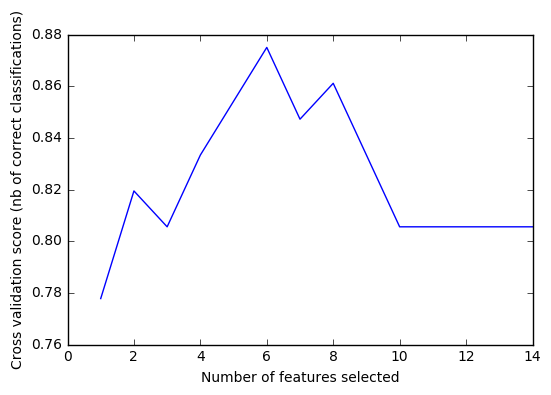

In [89]:
import matplotlib.pyplot as plt
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

features_list = ['poi'] + financial_features
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

print "Created labels"
# Create the RFE object and compute a cross-validated score.
# svc = DecisionTreeClassifier(min_samples_split=5)
clf = AdaBoostClassifier()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(6)) #scoring='accuracy'

print "About to fit data"

rfecv.fit(features, labels)

print "Done fitting data"

print("Optimal number of features : %d" % rfecv.n_features_)
print rfecv.ranking_

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# 'deferral_payments', 'total_payments', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 
# 'loan_advances', 'director_fees',
    

From above we can see there are two prominent features for the finance data, exercised_stock_options and other. 

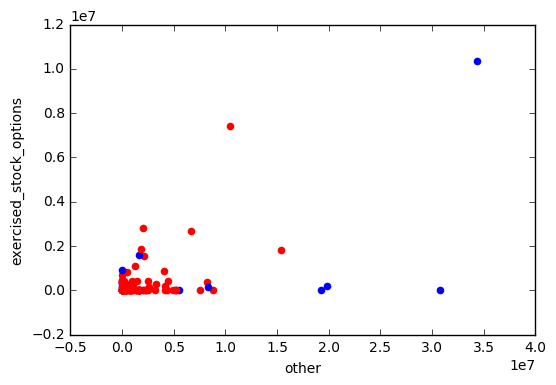

In [31]:
import matplotlib.pyplot as plt
poi_features = np.array([])
non_poi_features = np.array([])

poi_color = "b"
non_poi_color = "r"

data = featureFormat(data_dict, ['poi', 'exercised_stock_options', 'other'], sort_keys = True)

for person in data:
    if person[0] == 1: #poi
        plt.scatter( person[1], person[2], color=poi_color)
    else:
        plt.scatter( person[1], person[2], color=non_poi_color)

plt.xlabel('other')
plt.ylabel('exercised_stock_options')
plt.legend()
plt.show()

Created labels
About to fit data
Done fitting data
Optimal number of features : 5
[1 1 1 1 1]


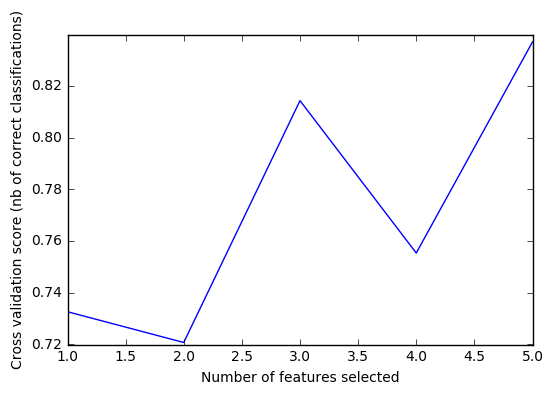

In [91]:
import matplotlib.pyplot as plt
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler

features_list = ['poi'] + numerical_email_features
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

scaled_features = MinMaxScaler().fit_transform(features)

print "Created labels"
# Create the RFE object and compute a cross-validated score.
# svc = DecisionTreeClassifier(min_samples_split=5)
clf = AdaBoostClassifier()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(4))

print "About to fit data"

rfecv.fit(scaled_features, labels)

print "Done fitting data"

print("Optimal number of features : %d" % rfecv.n_features_)
print rfecv.ranking_

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [94]:
def score(features_train, labels_train, features_test, labels_test):
    from sklearn.ensemble import AdaBoostClassifier
    
    clf = AdaBoostClassifier()
    clf.fit(features_train, labels_train)
    return clf.score(features_test, labels_test)

In [95]:
def pca_result(features, labels, n_components):
    from sklearn.decomposition import PCA

    clf = PCA(n_components=n_components)
    clf.fit(features)
    return clf

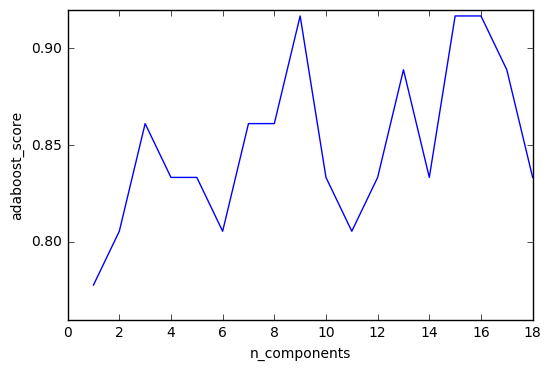

In [97]:
def graph_pca_score(features, labels):
    from sklearn.cross_validation import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)
    scores = []
    
    for i in xrange(1, len(features[0])):
        pca = pca_result(X_train, y_train, i)
        new_x_train = pca.transform(X_train)
        new_x_test = pca.transform(X_test)
        
        s = score(new_x_train, y_train, new_x_test, y_test)
        scores.append(s)
        
    plt.figure()
    plt.xlabel("n_components")
    plt.ylabel("adaboost_score")
    plt.plot(range(1, len(features[0])), scores)
    plt.show()
    
features_list = ['poi'] + numerical_email_features + financial_features
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features = MinMaxScaler().fit_transform(features)
    
graph_pca_score(features, labels)

It seems like 9 or 3 features has the best results. 9 is clearly the best, but this may be overfitting to the data. Using a smaller number of features (i.e. 3) could result in a better result. 